In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Collateralized Ad Auction

An ad auction is an auction where advertisers are bidding for a user's attention through an ad distributor (Google, Facebook, etc.). The advertiser pays the distributor some amount of money for their ad to show up on the user's browser.

Ads carry with them some value for the advertiser and, crucially, some value for the general social welfare. The social welfare value often comes through the ad's intended effect and truthfulness. For example, an ad that denies climate change would have a negative social welfare value, while one that encourages using clean energy might have a positive social welfare value.

Let's assume the auctioneer knows the true social welfare value for any ad. A penalized ad auction is one in which the advertiser who wins the auction pays an additional cost as a function of the ad's social welfare value. (this can equivalently be implemented through a collateralization mechanism with probabalistic auditing and loss of the collateral as a penalty).

This code implements a collateralized second-price ad auction. Advertisers place a bid only if their value is greater than the expected payment value plus the known penalty (or expected collateralization) payment for their ad. Their payment is the second highest bid. This ensures that advertisers bid their true values.

The advertiser's value is denoted $v$ where $v_1, v_2, ...$ are the highest value, second highest value, etc. The social welfare value is denoted $e$ where $e_1$ is the social welfare value of the ad with the highest advertiser value. Given a collateralization function ($C$) that returns the collateralization value for a given $e$, $\tau$ is a function that returns $C(e) + \mathbb{E}(v_2)$. An advertiser will only bid if their $v_i > \tau(v_i, e_i)$.

## Data

X data was collected from the X community notes files as well as from the X API. Posts were pulled from the API if they had a community note with at least 400 "HELPFUL" ratings. Post externality cost per 1000 impressions (CPM) was calculated by giving note types values between -3 and 3, and then subtracting the average rating where 'HELPFUL' = 1, 'SOMEWHAT_HELPFUL' = 0, and 'NOT_HELPFUL' = -1.

Average advertiser cost per first action data was pulled from [https://www.webfx.com/social-media/pricing/how-much-does-it-cost-to-advertise-on-twitter/](this website).

Post 'advertiser value' will be calculated during a simulation using this formula:
$$v = \text{random cost per action} * \frac{retweets+replies+likes+quotes+bookmarks}{impressions/1000}$$





In [2]:
tweet_data = pd.read_csv('full_tweets.csv')

print(tweet_data[['externality_cpm', 'action_count_per_1000_impressions']].describe())

average_ad_costs = [0.13,0.38,0.63,0.88,1.255,1.755,2.255,2.755,3.255]
# the 'not applicable' 2.5% was devided and distributed evenly to the other
# categories to create a pmf that sums to 1
ad_cost_probabilities = [0.1527777778,
                         0.1777777778,
                         0.1527777778,
                         0.1277777778,
                         0.09447777778,
                         0.08607777778,
                         0.06947777778,
                         0.08607777778,
                         0.05277777778]
# example usage: rng.choice(average_ad_costs, num_draws, p=ad_cost_probabilities) 

       externality_cpm  action_count_per_1000_impressions
count     11853.000000                       11853.000000
mean         -0.795309                           7.261223
std           0.412564                           8.994813
min          -1.530000                           0.000450
25%          -1.122226                           1.650213
50%          -0.712418                           4.360297
75%          -0.456341                           9.392109
max           0.176109                         125.404512


## Parameters

- `num_advertisers`: The number of advertisers participating in the auction
- `tau`: A function that returns the expected payment given an ad
- `ad_distribution`: A function that initializes $(v_i, e_i)$ pairs according to a given distribution

In [19]:
random_seed = 123
random.seed(random_seed)
rng = np.random.default_rng(random_seed)

num_auctions = 100
num_advertisers = 100
tau = lambda v, e: -0.5*e + 0.5

def ad_distribution():
    random_i = rng.integers(len(tweet_data))
    v = rng.choice(average_ad_costs, 1, p=ad_cost_probabilities) * tweet_data['action_count_per_1000_impressions'].iloc[random_i]
    e = tweet_data['externality_cpm'][random_i]
    return (v[0], e)

## Auction
1. Initialize advertiser ad values according to parameters
2. Run counterfactual second-price auction
 - Advertisers decide on bid ($v$, honest)
 - Everyone bids
 - Record $(v_1, e_1, v_1+e_1) = w_{vcg}$
3. Run collateralized second-price auction
 - Advertisers decide on bid ($v$, honest)
 - Advertisers with $v_i > \tau(v_i, e_i)$ place bid
 - Record $(v_1, e_1, v_1+e_1) = w_{coll}$

 Make change to allow for any number of accepted bids (k). If no advertisers pass the tau check, output welfare of 0. Output v-vector that is v1, v1+v2, v1+...+vk etc. Visualize:
 - histogram of welfare for given k
 - line (x=k, y=avg welfare for k)

In [28]:
def run_auction(num_advertisers, tau):

    # initialize advertisers
    advertisers = [ad_distribution() for _ in range(num_advertisers)]

    # run counterfactual auction
    counterfactual_bids = []
    for ad in advertisers:
        counterfactual_bids.append(ad)
    ## sort bids according to advertiser value
    counterfactual_bids.sort(key=lambda x: x[0])
    top_bid = counterfactual_bids[-1]
    w_vcg = (top_bid[0], top_bid[1], top_bid[0]+top_bid[1])

    # run collateralized auction
    collateralized_bids = []
    for ad in advertisers:
        if ad[0] >= tau(ad[0], ad[1]):
            collateralized_bids.append(ad)
    ## sort bids according to advertiser value
    collateralized_bids.sort(key=lambda x: x[0])
    top_bid = collateralized_bids[-1]
    w_coll = (top_bid[0], top_bid[1], top_bid[0]+top_bid[1])

    return w_vcg, w_coll, advertisers

def run_auctions(num_auctions, num_advertisers, tau):
    # output variables
    w_vcg = []
    w_coll = []
    advertisers = []

    for _ in range(num_auctions):
        w_vcg_i, w_coll_i, advertisers_i = run_auction(num_advertisers, tau)
        w_vcg.append(w_vcg_i)
        w_coll.append(w_coll_i)
        advertisers.append(advertisers_i)

    return w_vcg, w_coll, advertisers

def plot_auctions(w_vcg, w_coll):
    counterfactual_total_welfare = [w[2] for w in w_vcg]
    collateralized_total_welfare = [w[2] for w in w_coll]

    counterfactual_social_welfare = [w[1] for w in w_vcg]
    collateralized_social_welfare = [w[1] for w in w_coll]

    # plt.hist(counterfactual_total_welfare, bins=20, alpha=0.4, color='red', label='Counterfactual')
    # plt.hist(collateralized_total_welfare, bins=20, alpha=0.4, color='blue', label='Collateralized')
    plt.hist(
        [counterfactual_total_welfare, collateralized_total_welfare],
        bins=30,
        alpha=0.5,
        color=['red', 'blue'],
        label=['Counterfactual', 'Collateralized']
    )
    plt.legend(loc='upper right')
    plt.xlabel('Total Welfare')
    plt.ylabel('Frequency')
    plt.title('Total Welfare Distribution')
    plt.show()

    plt.hist(
        [counterfactual_social_welfare, collateralized_social_welfare],
        bins=30,
        alpha=0.5,
        color=['purple', 'green'],
        label=['Counterfactual', 'Collateralized']
    )
    plt.legend(loc='upper right')
    plt.xlabel('Social Welfare')
    plt.ylabel('Frequency')
    plt.title('Social Welfare Distribution')
    plt.show()
    
def plot_advertisers(advertisers):
    v = [ad[0] for ad in advertisers]
    e = [ad[1] for ad in advertisers]
    plt.scatter(e, v, alpha=0.5)
    plt.ylabel('Advertiser CPM')
    plt.xlabel('Externality CPM')
    plt.title('Social Welfare Values vs Advertiser Values')
    plt.show()

In [24]:
w_vcg, w_coll = run_auctions(1, 10, tau)

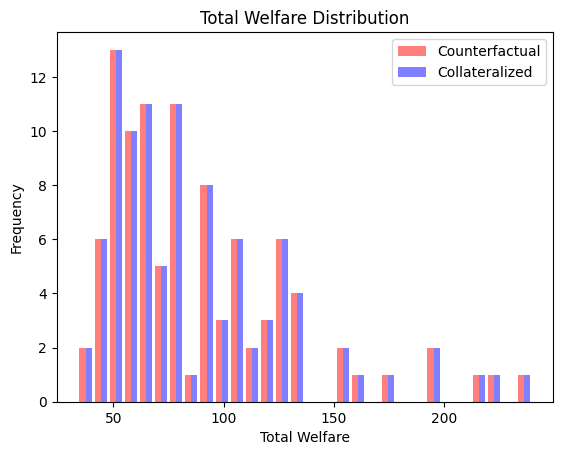

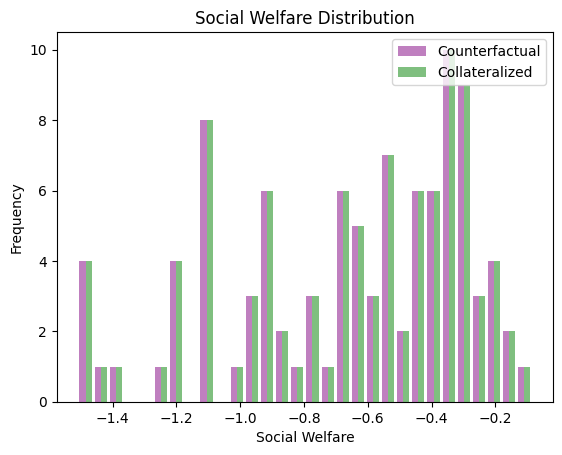

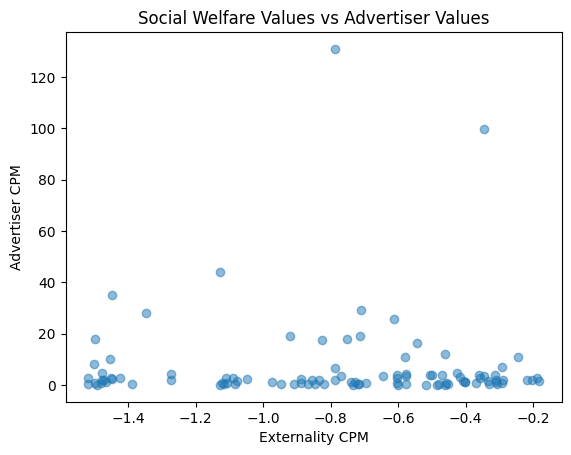

In [29]:
w_vcg, w_coll, advertisers = run_auctions(num_auctions, num_advertisers, tau)
plot_auctions(w_vcg, w_coll)
plot_advertisers(advertisers[0])